#Drug Discovery using the ChEMBL Webresource Client

This is the third version of a drug discovery project notebook created by Chanin Nantasenamat & Ian Johnson.

Changes in this version:

* All the necessary downloads and imports are made up front. This notebook should run in Colab so long as the end user mounts his/her own Google Drive and specifies an output folder path.

* The target protein is acetylcholinesterase (AChE) as observed in the common rat. The human version of this enzyme may be used as well but the data will take longer to load.

* An example molecule from the dataset is depicted.

* Functions used to process and visualize the data are made more 'Pythonic' resulting in much fewer lines of code.

* Molecules appearing in the dataset more than once (due to multiple assays using that molecule) are limited to the observation with the smallest IC50 value (highest potency.) It's worth noting that there is variance in IC50 measurements for identical molecule-target protein pairs.

* Plots use FiveThirtyEight styling.

* k-Fold Cross-Validation for choosing model hyperparameters.

* Baseline dummy regressor.

* This notebook will create three files when ran from start to finish.
  * a csv file of bioactivity data resulting from querying the client for the specific protein
  * a csv file containing preprocessed data with added columns for Lapinski descriptors, $pIC_{50}$ values, and a binary class variable ('ACTIVE', 'INACTIVE') indicating whether or not each molecule is reactive with the target.
  * a csv file containing the chemical fingerprint for each molecule in the dataset (the function to create this file probably needs to be optimized using the *padeldescriptor* import because it has a very long runtime)

The model used - a random forest regressor - achieves an $R^2$ of .72 in this example. In other words, 72 percent of the variance in [potency](https://en.wikipedia.org/wiki/Potency_(pharmacology)) (as measured by $pIC_{50}$) is explained by the chemical fingerprint of the molecule.

#Imports

In [ ]:
%%bash
pip install chembl_webresource_client
pip install padelpy
wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
conda install -c rdkit rdkit -y

In [2]:
import sys

sys.path.append('/usr/local/lib/python3.7/site-packages/') #path to RDKit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as scs

plt.rcParams['figure.figsize'] = (6, 6)
plt.style.use('fivethirtyeight')

from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors, Lipinski
from padelpy import padeldescriptor, from_smiles

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score

#GDrive mounted using sidebar
PATH = "/content/drive/MyDrive/Colab Notebooks/data/chembl/" #folder for files

#Acquire

In [5]:
TARGET_NAME = "acetylcholinesterase" #enzyme associated with Alzheimer's
STANDARD_TYPE = "IC50"
TARGET_ID = 3199 #AChE Rattus norvegicus

In [4]:
query = new_client.target.search(TARGET_NAME)
targets = pd.DataFrame(query)
targets.head(6)

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P22303', 'xref_name': None, 'xre...",Homo sapiens,Acetylcholinesterase,27.0,False,CHEMBL220,"[{'accession': 'P22303', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Homo sapiens,Cholinesterases; ACHE & BCHE,27.0,False,CHEMBL2095233,"[{'accession': 'P06276', 'component_descriptio...",SELECTIVITY GROUP,9606
2,[],Drosophila melanogaster,Acetylcholinesterase,17.0,False,CHEMBL2242744,"[{'accession': 'P07140', 'component_descriptio...",SINGLE PROTEIN,7227
3,"[{'xref_id': 'P04058', 'xref_name': None, 'xre...",Torpedo californica,Acetylcholinesterase,15.0,False,CHEMBL4780,"[{'accession': 'P04058', 'component_descriptio...",SINGLE PROTEIN,7787
4,"[{'xref_id': 'P21836', 'xref_name': None, 'xre...",Mus musculus,Acetylcholinesterase,15.0,False,CHEMBL3198,"[{'accession': 'P21836', 'component_descriptio...",SINGLE PROTEIN,10090
5,"[{'xref_id': 'P37136', 'xref_name': None, 'xre...",Rattus norvegicus,Acetylcholinesterase,15.0,False,CHEMBL3199,"[{'accession': 'P37136', 'component_descriptio...",SINGLE PROTEIN,10116


The **standard_value** column represents **potency**. A lower value means a smaller dose is needed to exhibit an effect while higher value means the compound is less potent. Here is how to retrieve bioactivity data for a target protein. The standard_type='IC50' filters for bioactivity tests using the IC50 standard.

In [ ]:
result = new_client.activity.filter(target_chembl_id = "CHEMBL"+str(TARGET_ID)).filter(standard_type=STANDARD_TYPE)
df = pd.DataFrame(result).dropna(subset=["value"]) #drop row if standard_value is missing
df.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,32049,[],CHEMBL642843,Effect on Acetylcholinesterase activity in rat...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC[N+](C)(CC)CC(=O)CCN1C(=O)CCC1=O.[I-],None,None,CHEMBL1123058,J. Med. Chem.,1985,"{'bei': '15.67', 'le': '0.30', 'lle': '3.42', ...",CHEMBL15886,None,CHEMBL1178213,4.00,False,http://www.openphacts.org/units/Nanomolar,17693,=,1,True,=,None,IC50,nM,None,100000.0,CHEMBL3199,Rattus norvegicus,Acetylcholinesterase,10116,None,None,I50,mM,UO_0000065,None,0.1
1,None,32050,[],CHEMBL642842,Effect on Acetylcholinesterase activity in rat...,B,None,None,BAO_0000190,BAO_0000221,tissue-based format,CC[N+](C)(CC)CC(=O)CCN1C(=O)CCC1=O.[I-],Outside typical range,Values for this activity type are unusually la...,CHEMBL1123058,J. Med. Chem.,1985,None,CHEMBL15886,None,CHEMBL1178213,None,False,http://www.openphacts.org/units/Nanomolar,17693,=,1,True,=,None,IC50,nM,None,170000.0,CHEMBL3199,Rattus norvegicus,Acetylcholinesterase,10116,None,None,I50,mM,UO_0000065,None,0.17
2,None,34486,[],CHEMBL642843,Effect on Acetylcholinesterase activity in rat...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,C[n+]1ccccc1CCC(O)CCl.[I-],Outside typical range,Values for this activity type are unusually la...,CHEMBL1123058,J. Med. Chem.,1985,None,CHEMBL556129,None,CHEMBL1196197,None,False,http://www.openphacts.org/units/Nanomolar,17691,=,1,True,=,None,IC50,nM,None,200000.0,CHEMBL3199,Rattus norvegicus,Acetylcholinesterase,10116,None,None,I50,mM,UO_0000065,None,0.2
3,None,34487,[],CHEMBL642842,Effect on Acetylcholinesterase activity in rat...,B,None,None,BAO_0000190,BAO_0000221,tissue-based format,C[n+]1ccccc1CCC(O)CCl.[I-],Outside typical range,Values for this activity type are unusually la...,CHEMBL1123058,J. Med. Chem.,1985,None,CHEMBL556129,None,CHEMBL1196197,None,False,http://www.openphacts.org/units/Nanomolar,17691,=,1,True,=,None,IC50,nM,None,200000.0,CHEMBL3199,Rattus norvegicus,Acetylcholinesterase,10116,None,None,I50,mM,UO_0000065,None,0.2
4,None,38116,[],CHEMBL642843,Effect on Acetylcholinesterase activity in rat...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,C[N+](C)(C)CCCCl.[Br-],Outside typical range,Values for this activity type are unusually la...,CHEMBL1123058,J. Med. Chem.,1985,None,CHEMBL15795,None,CHEMBL1178211,None,False,http://www.openphacts.org/units/Nanomolar,17688,=,1,True,=,None,IC50,nM,None,260000.0,CHEMBL3199,Rattus norvegicus,Acetylcholinesterase,10116,None,None,I50,mM,UO_0000065,None,0.26


In [ ]:
df.to_csv(PATH+f'{TARGET_ID}_bioactivity_data.csv', index=False)

A list of the molecules tested against our target.

In [ ]:
df.molecule_chembl_id

0         CHEMBL15886
1         CHEMBL15886
2        CHEMBL556129
3        CHEMBL556129
4         CHEMBL15795
            ...      
1685    CHEMBL4475678
1686    CHEMBL4451935
1687        CHEMBL636
1688        CHEMBL502
1689     CHEMBL231160
Name: molecule_chembl_id, Length: 1690, dtype: object

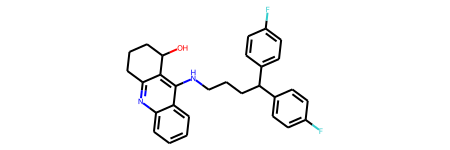

In [ ]:
#here is an example of the molecular structure we're using to predict potency with AChE
Chem.MolFromSmiles(df.canonical_smiles[36])

#Prepare

In [30]:
df = pd.read_csv(PATH+f'{TARGET_ID}_bioactivity_data.csv')

In [31]:
def bioactivity_class(df):
  '''Divide compounds into potency classes.
  '''
  class_names = []
  for i in df.standard_value:
    if i >= 10000:
      class_names.append('INACTIVE')
    elif i <= 1000:
      class_names.append('ACTIVE')
    else: class_names.append('intermediate')

  df['bioactivity_class'] = class_names

  return df

In [32]:
subset = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']

act_df = df.copy()[subset]
l1 = len(act_df)
act_df = bioactivity_class(act_df)
act_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690 entries, 0 to 1689
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  1690 non-null   object 
 1   canonical_smiles    1690 non-null   object 
 2   standard_value      1690 non-null   float64
 3   bioactivity_class   1690 non-null   object 
dtypes: float64(1), object(3)
memory usage: 52.9+ KB


Calculate Lipinski Descriptors (describe druglikeness). [SMILES](https://en.wikipedia.org/wiki/SMILES_arbitrary_target_specification) is a chemical notation that describes a compounds chemical structure. This functon makes a dataframe with the four parameters described by [Lipinski's RO5](https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five) and has the same number of rows as *bioactivity_df*.

In [33]:
def lipinski(smiles):
  '''Using SMILES notation, returns the four parameters
  described by Lipinski's RO5 in dataframe.'''

  moldata = [Chem.MolFromSmiles(elem) for elem in smiles]
  desc = pd.DataFrame(data=np.zeros((len(moldata), 4)),
                      columns=['MW', 'LogP', 'NumHDonors', 'NumHAcceptors'])
  
  for ix, mol in enumerate(moldata):
    desc.loc[ix] = [Descriptors.MolWt(mol), Descriptors.MolLogP(mol),
                    Lipinski.NumHDonors(mol), Lipinski.NumHAcceptors(mol)]
                    
  return desc

IC50 has an uneven distribution. Taking the negative log makes the distribution more even.


In [39]:
def pIC50(df):
  '''Convert IC50 to pIC50, capping input at 100M,
  which would give negative values after negative logarithm.'''
  
  pIC50 = []
  for ic in df.standard_value:
    ic = min(ic, 1e8)
    molar = ic* 1e-9 #converts nanomolar to molar
    pIC50.append(round(-np.log10(molar), 2)) #three significant digits

  df['pIC50'] = pIC50
  return df

In [35]:
lipinski_df = lipinski(act_df.canonical_smiles)
act_df = pd.concat([act_df, lipinski_df], axis=1)
act_df = pIC50(act_df)
act_df.pIC50.describe()

count    1690.000000
mean        6.038266
std         1.424383
min         1.320000
25%         5.000000
50%         6.060000
75%         7.097500
max        11.050000
Name: pIC50, dtype: float64

First, we'll drop the intermediate class which are molecules sitting in the gray area between active and active. Second, we'll groupby molecule, keeping the higher potency/lower IC50 measurement where applicable. Leaving duplicate compounds in dataset may create data leakage.

In [36]:
act_df = act_df[act_df.bioactivity_class != 'intermediate']
l2 = len(act_df)
print((l1-l2), 'rows dropped.')
act_df = act_df.groupby('molecule_chembl_id').min()
print((l2-len(act_df)), 'rows dropped.')

398 rows dropped.
192 rows dropped.


In [37]:
act_df.tail()

,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
molecule_chembl_id,,,,,,,,
CHEMBL96406,CC1=NC2CCCc3nc4ccccc4c(c32)N1,100000.0,INACTIVE,237.306,3.4561,1.0,3.0,4.00
CHEMBL96542,CN1CCN(C2CCCc3nc4ccccc4c(N)c32)CC1,100000.0,INACTIVE,296.418,2.4418,1.0,4.0,4.00
CHEMBL96588,Nc1c2c(nc3ccccc13)CCCC2NCc1ccccc1,20100.0,INACTIVE,303.409,3.9842,2.0,3.0,4.70
CHEMBL96643,CCCOC1CCCc2nc3ccccc3c(N)c21,193.0,ACTIVE,256.349,3.6210,1.0,3.0,6.71
CHEMBL96861,CCCCCC(=O)NC1CCCc2nc3ccccc3c(N)c21,51800.0,INACTIVE,311.429,3.8909,2.0,3.0,4.29


In [38]:
act_df.to_csv(PATH+f'{TARGET_ID}_bioactivity_preprocessed.csv', index=True)

# Explore

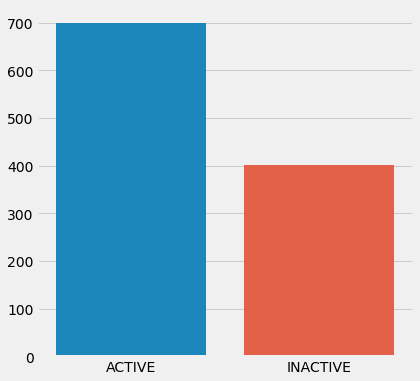

In [40]:
#Frequency plot of bioactivity classes
ax = sns.countplot(x='bioactivity_class', data=act_df)
#ax.bar_label(ax.containers[0]) #numeric labels for bars?
plt.xlabel('')
plt.ylabel('')
plt.show()


The two bioactivity classes are spanning similar [chemical spaces](https://en.wikipedia.org/wiki/Chemical_space), as shown in the plot below.


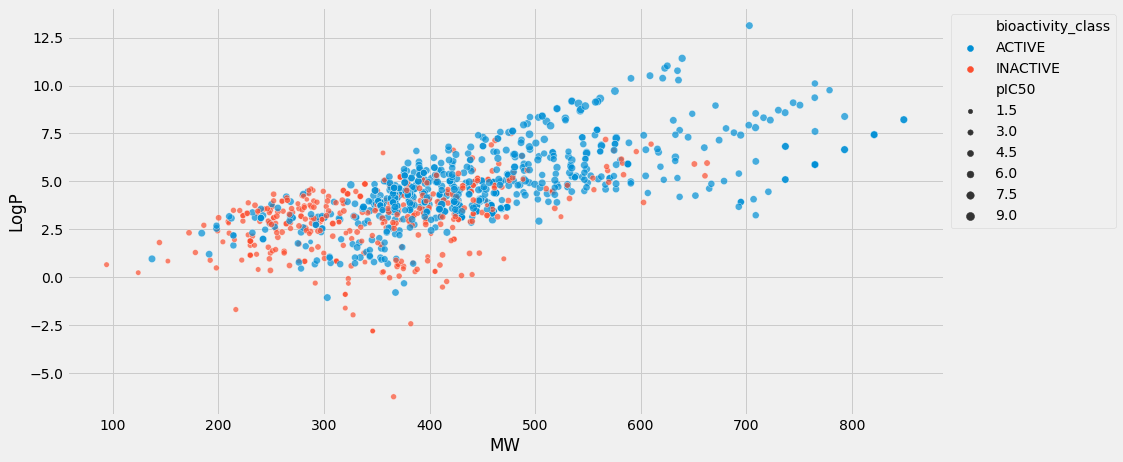

In [41]:
plt.figure(figsize=(14, 7))
sns.scatterplot(x='MW', y='LogP', data=act_df, hue='bioactivity_class', size='pIC50', alpha=.7)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [42]:
def boxplot_mannwhitney(descriptor, df, alpha=.05):
  '''Compare and interpret the active and inactive samples
  using a boxplot and Mann-Whitney U test.
  '''
  
  sns.boxplot(x='bioactivity_class', y=descriptor, data=df)
  plt.xlabel('')
  plt.show()

  active = df[df.bioactivity_class=='ACTIVE'][descriptor]
  inactive = df[df.bioactivity_class=='INACTIVE'][descriptor]
  stat, p = scs.mannwhitneyu(active, inactive)
  print('Statistic=%.0f, p=%.3f' %(stat, p))

  if p > alpha:
    print('Same distribution (fail to reject H0)')
  else:
    print('Different distribution (reject H0)')

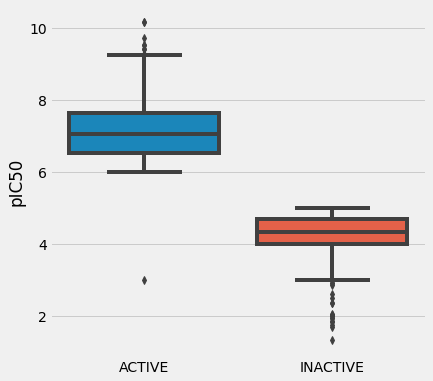

Statistic=383, p=0.000
Different distribution (reject H0)


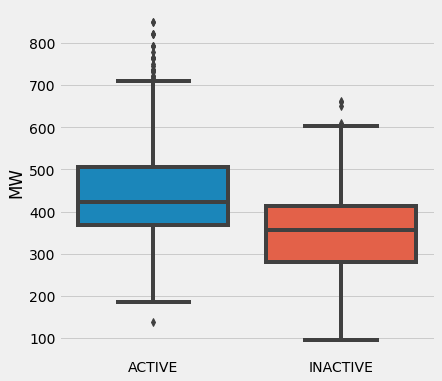

Statistic=75356, p=0.000
Different distribution (reject H0)


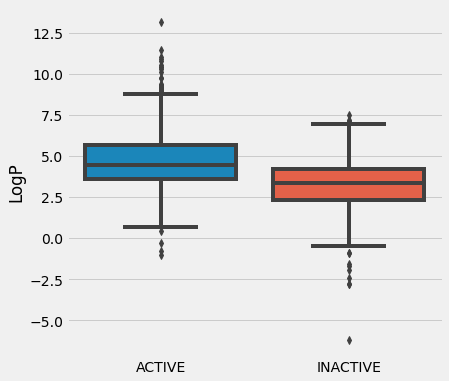

Statistic=75308, p=0.000
Different distribution (reject H0)


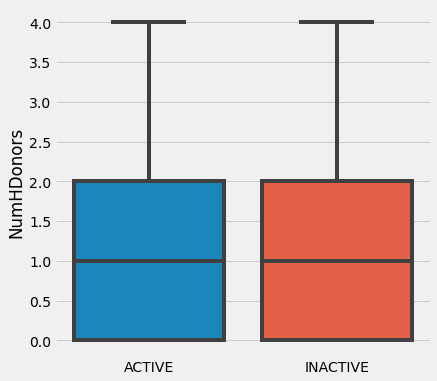

Statistic=128874, p=0.010
Different distribution (reject H0)


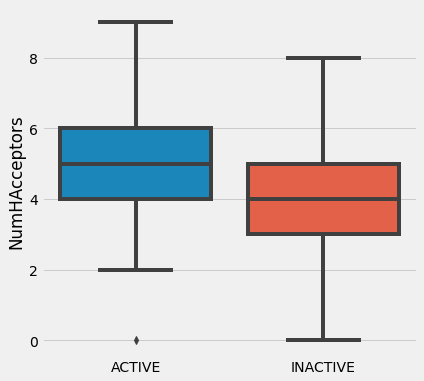

Statistic=94710, p=0.000
Different distribution (reject H0)


In [43]:
for col in ['pIC50', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors']:
  boxplot_mannwhitney(col, act_df)

pIC50 values were statistically significant, which is expected because we classified active vs. inactive by IC50.

Are the Lipinski descriptors statistically significant between active and inactive molecules? Yes.


#Model

In [44]:
TARGET_ID = 3199 #AChE Rattus norvegicus

df = pd.read_csv(PATH+f'{TARGET_ID}_bioactivity_preprocessed.csv', index_col=0)
smile_df = df[['canonical_smiles', 'pIC50']].dropna()
smile_df = smile_df[:200] #cutoff to limit runtime
print(len(smile_df), "unique compund fingerprints will be computed.")

200 unique compund fingerprints will be computed.


In [45]:
#LONG RUNTIME ~10 minutes
fps = from_smiles(list(smile_df.canonical_smiles),
                  fingerprints=True, descriptors=False,
                  timeout=7200)

In [46]:
fps_df = pd.DataFrame(fps).set_index(smile_df.index)
fps_df = pd.concat([smile_df, fps_df], axis=1)
fps_df.to_csv(PATH+f'{TARGET_ID}_chem_fingerprints.csv', index=True)

In [47]:
#start here if loading fingerprints from a file
fps_df = pd.read_csv(PATH+f'{TARGET_ID}_chem_fingerprints.csv').iloc[:, 2:].dropna()
fps_df.tail()

,pIC50,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
195,4.49,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
196,4.21,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
197,2.86,1,1,1,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
198,3.59,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
199,3.32,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
y = fps_df.pop('pIC50') #response variable

In [49]:
selector = VarianceThreshold(.1)
X = selector.fit_transform(fps_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=36)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((160, 181), (160,), (40, 181), (40,))

We've already dropped features with low variance (under 0.1) thereby reducing the fingerprint from 881 to 100-200 features. Now try to maximize the cross-validation score in order to find the best hyperparameters.

 From the scikit-learn docs: 

`A random forest regressor a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.`


In [50]:
rfr = RandomForestRegressor(n_estimators=1000,
                            ccp_alpha=.01,
                            random_state=36)

cv_scores = cross_val_score(rfr, X_train, y_train, cv=5)
print("Scores:", cv_scores)
print("Maximize the average:", round(cv_scores.mean(),3))

Scores: [0.5365147  0.66662699 0.63242447 0.77042737 0.80194167]
Maximize the average: 0.682


In [59]:
#Baseline
print("Always predict", y_train.median())
dr = DummyRegressor(strategy='median')
#Evaluation
dr.fit(X_train, y_train)
print("R^2:", round(dr.score(X_test, y_test),3))

Always predict 6.575
R^2: -0.22


In [52]:
#Best model evaluation
rfr.fit(X_train, y_train)
print("Best model R^2:", round(rfr.score(X_test, y_test),3))

Best model R^2: 0.731


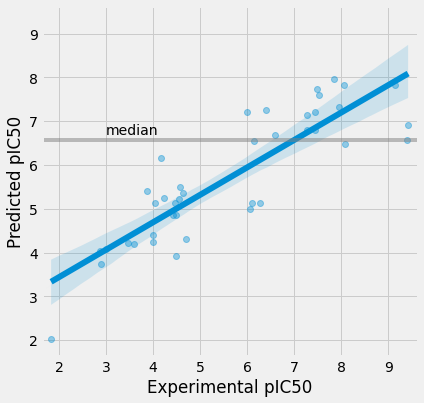

In [65]:
predictions = rfr.predict(X_test)

ax = sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha':.4})
ax.axhline(y_train.median(), color='gray', alpha=.5)
ax.text(3, 6.7, 'median')
ax.set_xlabel('Experimental pIC50')
ax.set_ylabel('Predicted pIC50')
pIC50_range = (y_test.min()-.2, y_test.max()+.2)
ax.set_xlim(pIC50_range)
ax.set_ylim(pIC50_range)
plt.show()